# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Normalize data and create embedding of the CD45+ compartment from the T0 (tumor resection)

## Libraries

In [2]:
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(here)
library(glue)
library(scater) 
library(scran)
}))

## Parameters

In [3]:
#here::dr_here(show_reason = TRUE)
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue() %>%
  here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue() %>%
  here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here(glue("{qc}/{robj_dir}/clean_combined_object_T0_CD45pos.rds")))

## Normalization and linear dimensional reduction

In [5]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [6]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 31072 13097 
metadata(0):
assays(2): counts logcounts
rownames(31072): AL627309.1 AL627309.3 ... AC007325.4 AC007325.2
rowData names(0):
colnames(13097): AAACCTGAGAAGGTGA-1 AAACCTGAGAGACGAA-1 ...
  TTTGTCATCGTAGGAG-1 TTTGTCATCGTTGCCT-1
colData names(12): orig.ident nCount_RNA ... doublet_pred ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


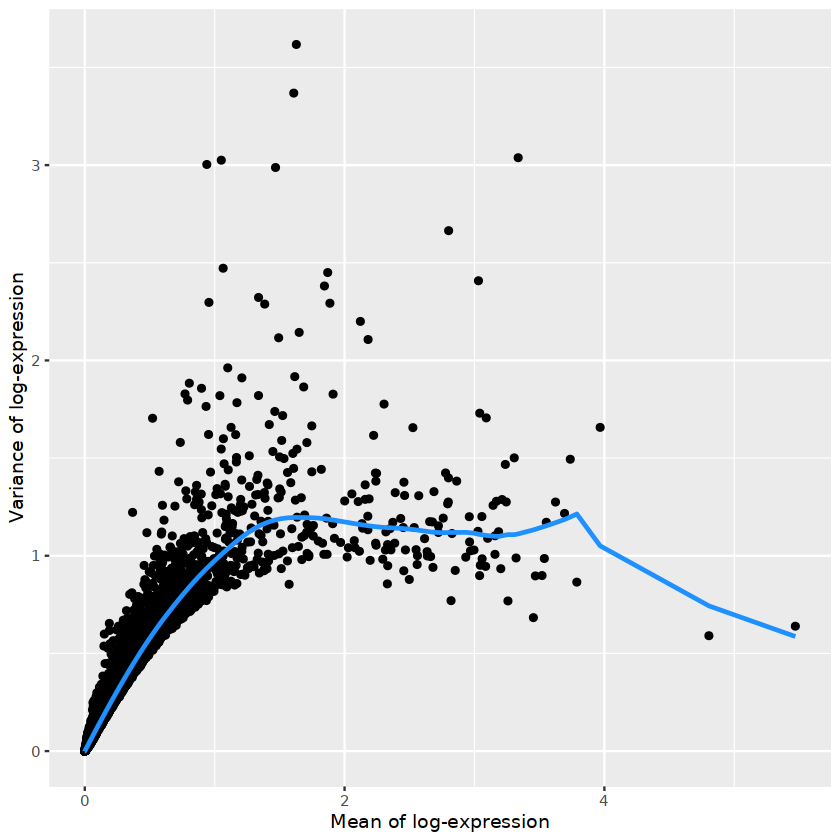

In [7]:
gene_var <- modelGeneVar(sce)
gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")

In [8]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

,mean,total,tech,bio,p.value,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CCL5,1.6286689,3.617756,1.1962155,2.4215405,6.555688e-31,1.059089e-27
NKG7,1.6087168,3.368752,1.1958377,2.1729145,2.773215e-25,2.503643e-22
HSPA1A,3.3364420,3.037957,1.1119426,1.9260145,3.770663e-23,2.630466e-20
S100A9,1.0509765,3.025245,1.0059899,2.0192550,2.011367e-30,3.086945e-27
S100A8,0.9395074,3.003355,0.9356680,2.0676871,1.878406e-36,7.207210e-33
IL32,1.4684999,2.987834,1.1837514,1.8040824,2.394824e-18,1.185631e-15
CD74,2.8010962,2.664432,1.1189650,1.5454667,2.138251e-15,7.292625e-13
CCL4,1.0650796,2.472168,1.0144465,1.4577214,1.626156e-16,6.399343e-14
FOS,1.8701960,2.450045,1.1875530,1.2624917,7.723018e-10,1.445476e-07


In [9]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 562

In [10]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 476

In [11]:
VariableFeatures(seurat_obj) <- hvgs

In [12]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  B2M, SRGN, HLA-B, HSPA1A, CD74, ZFP36, DNAJB1, NKG7, FOS, HSPA1B 
	   TYROBP, CST7, FCER1G, CCL5, JUN, GZMA, CTSW, SAT1, CD69, RGS1 
	   GZMK, IL32, PRF1, CCL4, CCL3, S100A4, CD3E, S100A11, GZMB, KLRB1 
Negative:  COL1A2, COL5A2, COL3A1, ROBO1, LRFN5, MEG3, NRG3, AC109466.1, NRXN1, PCDH9 
	   ERBB4, CNTNAP2, MDGA2, NLGN1, SPARC, COL11A1, CALD1, COL1A1, CADM2, DGKB 
	   NDUFA4L2, COL25A1, CCDC102B, MGP, PRKG1, FN1, EBF1, RBMS3, CCSER1, ADGRB3 
PC_ 2 
Positive:  CST7, CCL5, NKG7, GZMA, CTSW, CD69, IL32, PRF1, GZMK, IFITM1 
	   CCL4, CD3E, GZMB, KLRD1, RGS1, KLRB1, CD3D, CCL3, CCL4L2, IFNG 
	   KLRC1, XCL1, XCL2, GNLY, LTB, CTLA4, VCAM1, IL7R, B2M, FXYD2 
Negative:  VCAN, IFI30, LYZ, S100A9, FCN1, AIF1, S100A8, SERPINA1, SLC11A1, ACSL1 
	   PLXDC2, GLUL, RNF144B, CD14, SLC8A1, CD163, ZEB2, S100A11, NEAT1, PLAUR 
	   THBS1, S100A12, SAT1, S100A6, DOCK4, TYROBP, HLA-DRA, BAG3, FCER1G, DNAJA4 
PC_ 3 
Positive:  COL4A2, COL4A1, MYO1B, ABCC9

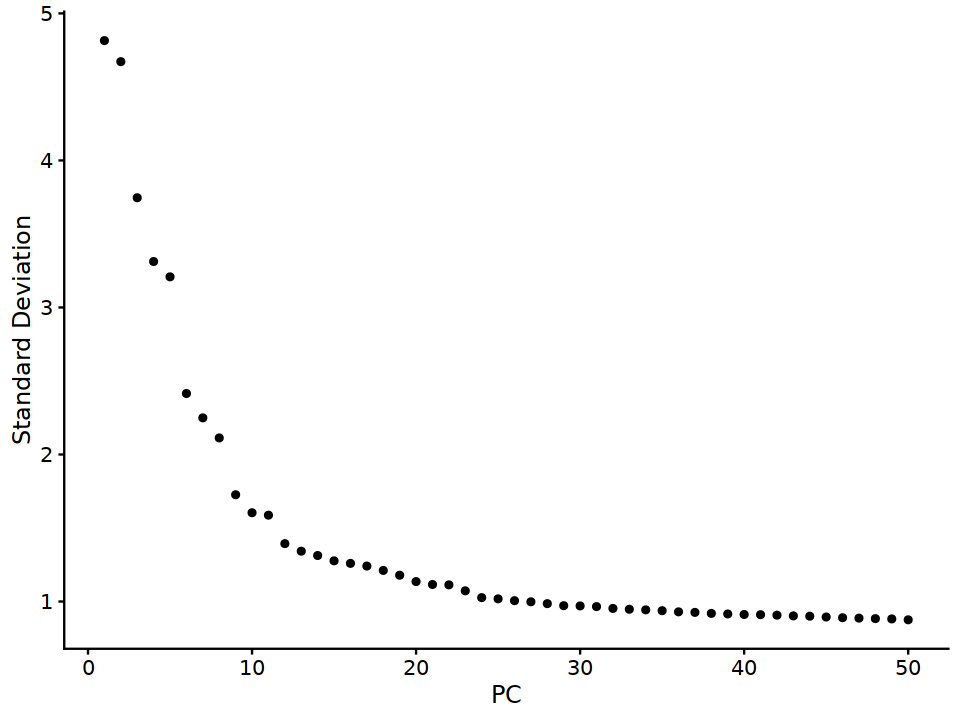

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

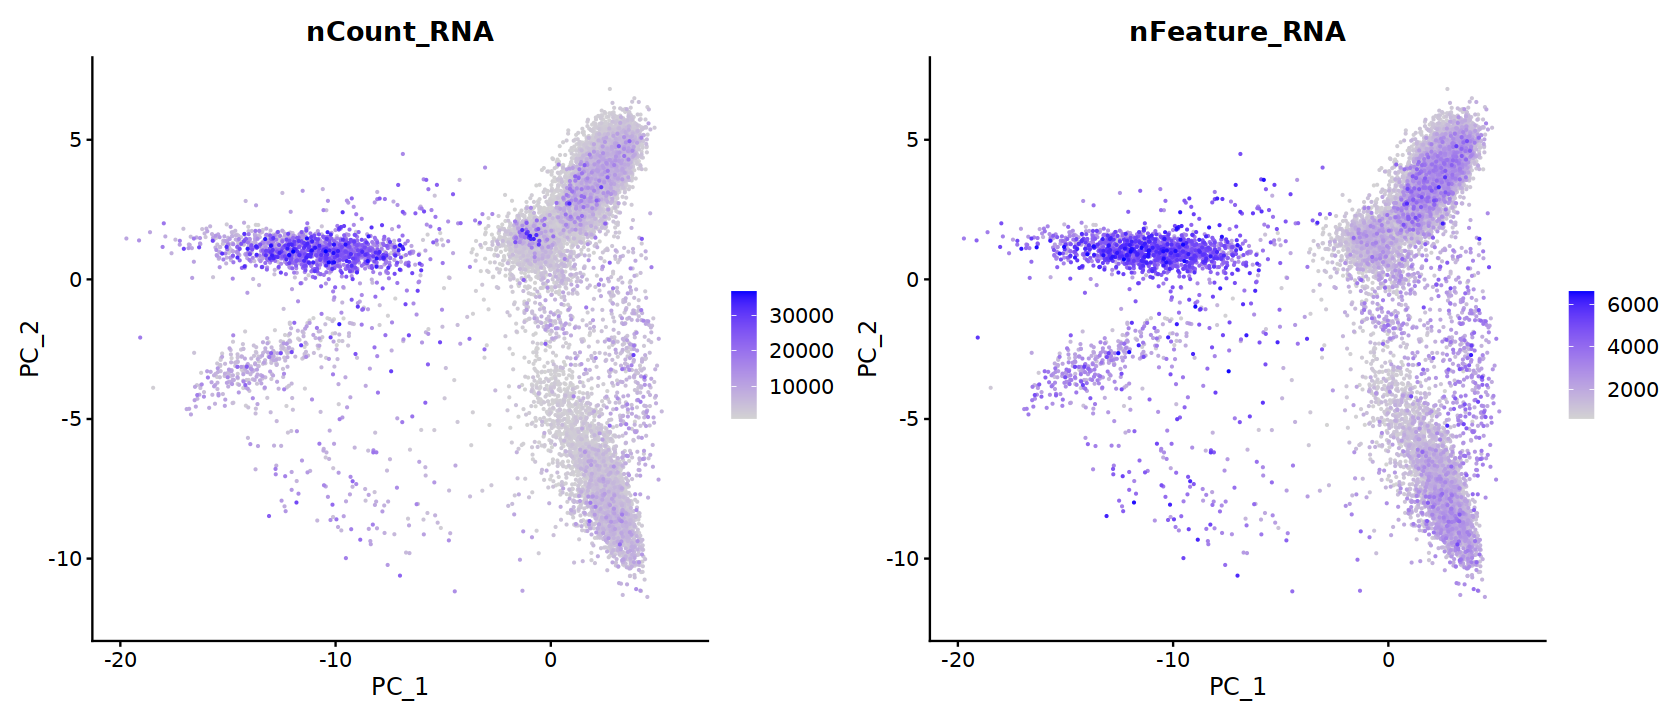

In [14]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

## UMAP representation

In [15]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:20,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:17:24 UMAP embedding parameters a = 0.9922 b = 1.112

12:17:24 Read 13097 rows and found 20 numeric columns

12:17:24 Using Annoy for neighbor search, n_neighbors = 30

12:17:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:17:26 Writing NN index file to temp file /scratch_tmp/33937378/RtmpBLAef9/file21d377c97e17f

12:17:26 Searching Annoy index using 1 thread, search_k = 3000

12:17:30 Annoy recall = 100%

12:17:30 Commencing smooth kNN distance calibration using 1 thread
 with t

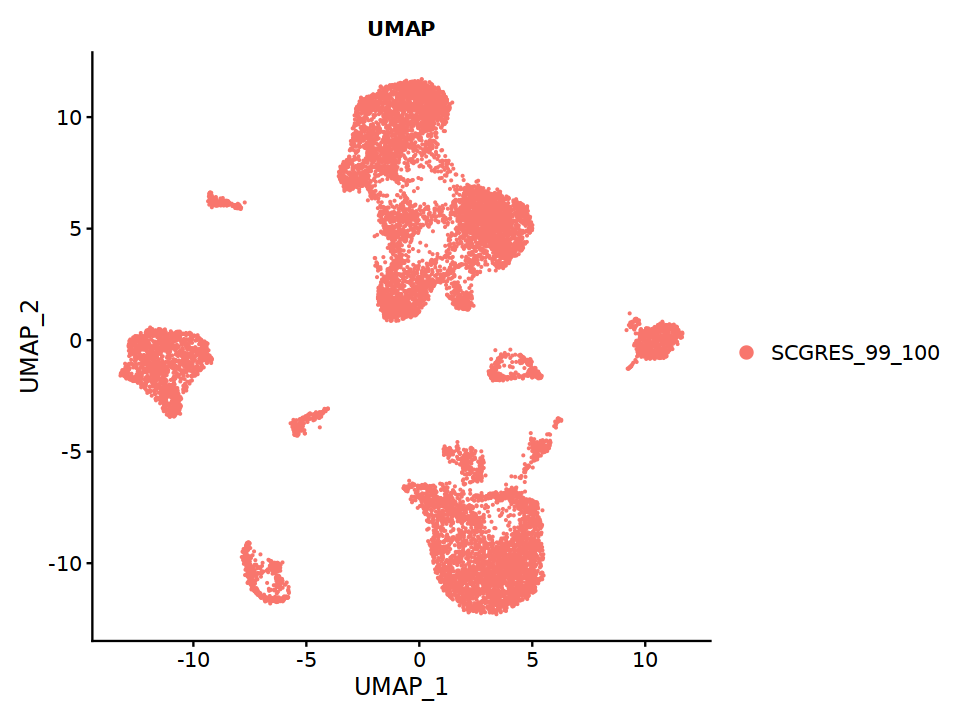

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle('UMAP') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [17]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [18]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "COL1A2")
vars <- c(cat_vars, con_vars)

In [19]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

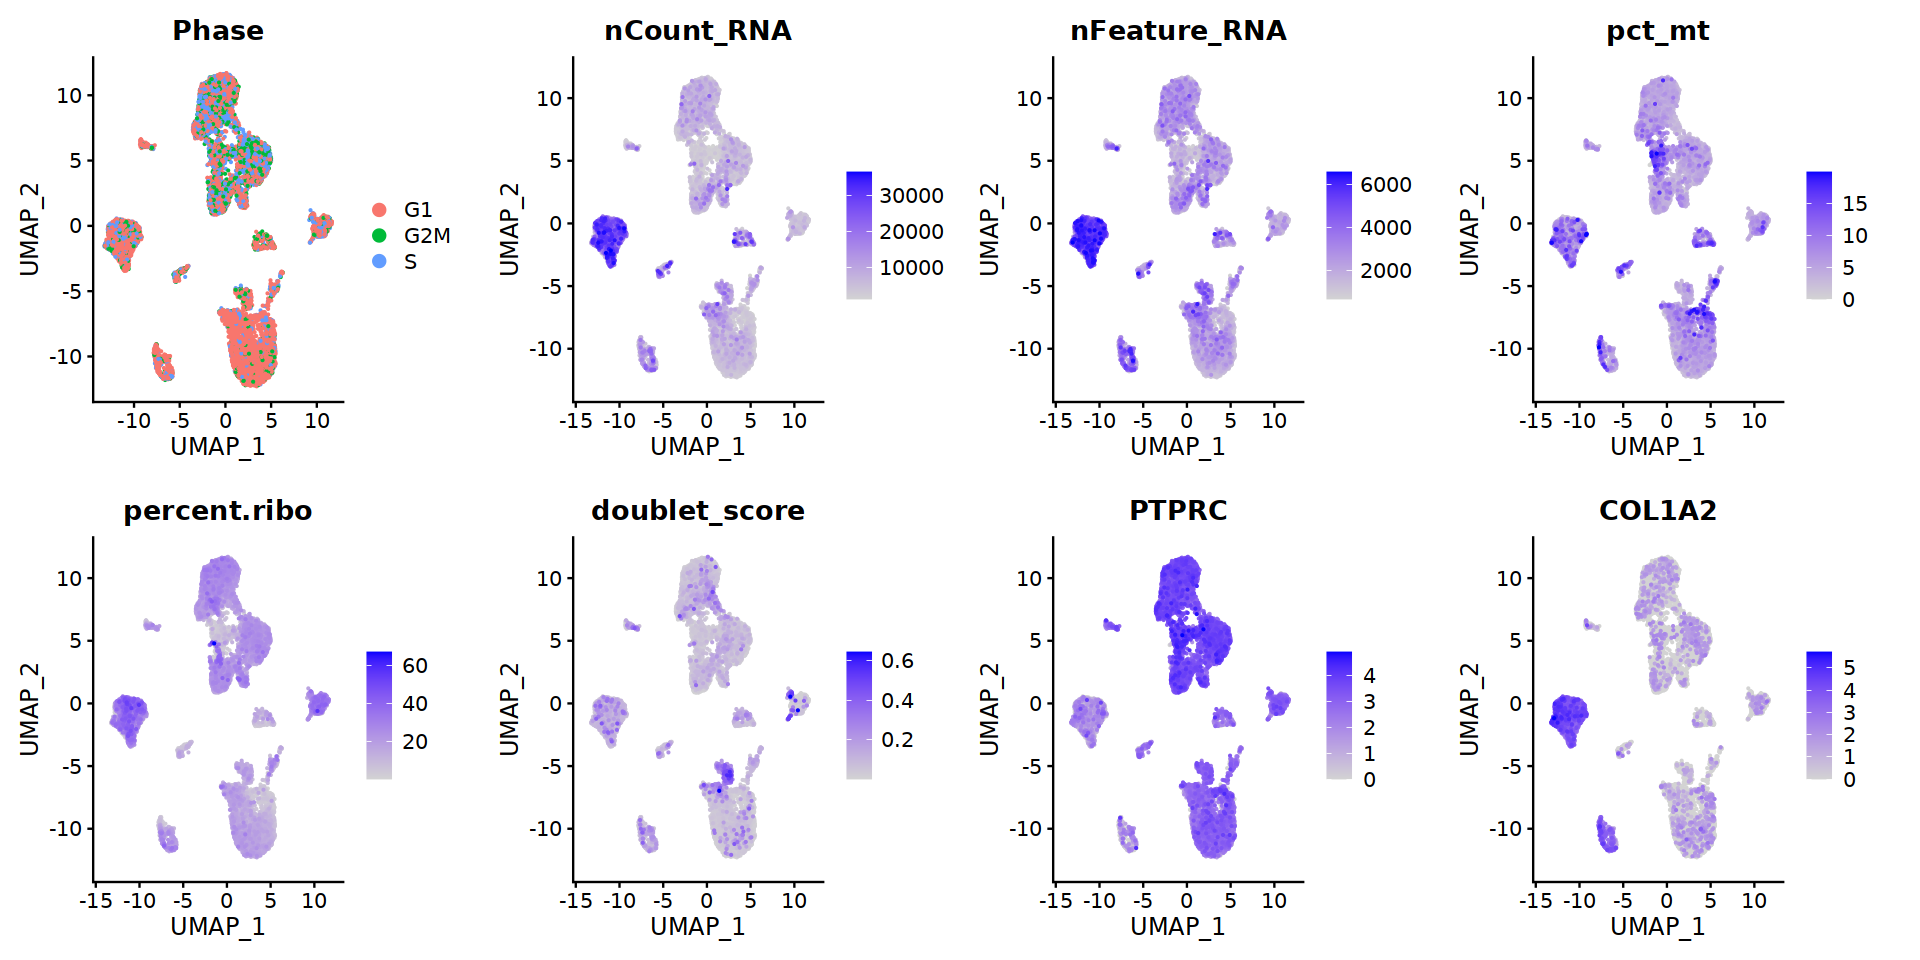

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)
cp

Potential doublets

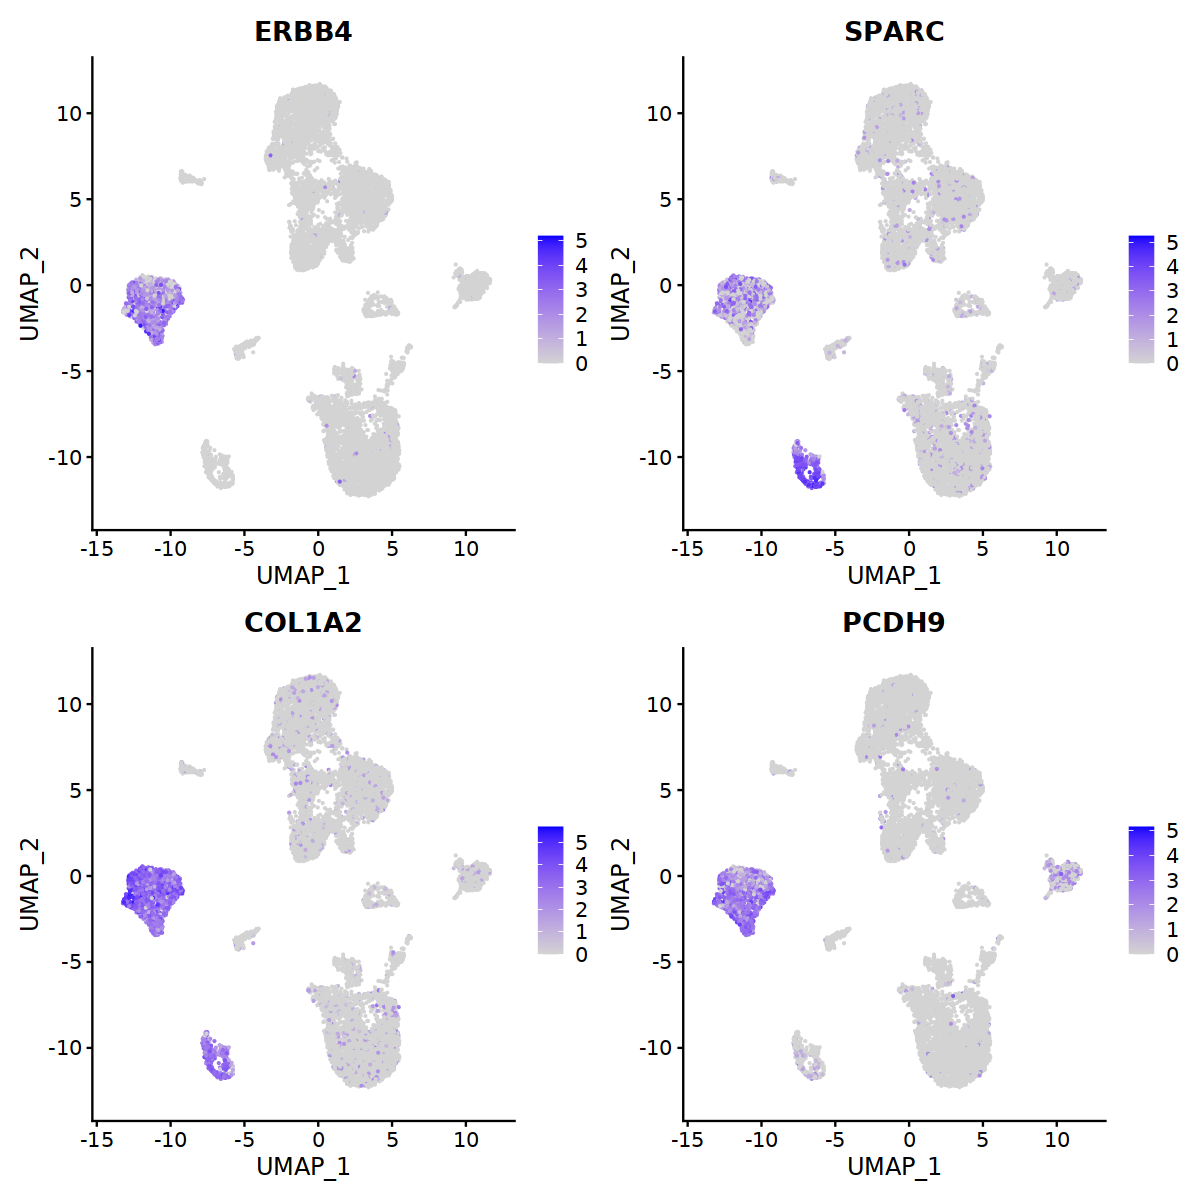

In [21]:
options(repr.plot.width = 10, repr.plot.height = 10, warn=-1,verbose = FALSE) 
FeaturePlot(seurat_obj, reduction = "umap", 
             feature=c("ERBB4", "SPARC", "COL1A2", "PCDH9"), order = FALSE)

# Save

In [22]:
saveRDS(seurat_obj, here(glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD45pos.rds")))

# Session Info

In [23]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_